# ASSIGNMENT

In a clean notebook, using the **Seattle Bicycle Weather** dataset, make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

In [11]:
# Holy Trinity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [5]:
# Import original load function for Bike dataframe
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

daily = load()

In [6]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [7]:
# Jake Vanderplas feature engineering

def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [8]:
data = load()

In [15]:
# Refactored Data Cleaning

def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)
    
    # DS3 AW
    
    X['is_warm'] = X['Temp (C)'] > 7
    first_nice = []
    for i in np.arange(len(X)):
        first_nice.append((X['is_warm'].iloc[range(i - 3 , i )].sum() < 1) & 
                          (X['is_warm'].iloc[i] == True) & 
                          (X['dry day'].iloc[i] == 1))
    
    X['first_nice_day'] = first_nice
    
    first_dry = []
    for i in np.arange(len(X)):
        (first_dry.append((X['dry day'].iloc[range(i - 3 , i )].sum() < 1) &
                          (X['dry day'].iloc[i] == True)))
                     
    X['first_dry_day'] = first_dry

    return X

In [16]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [20]:
print(X_train.shape,'\n')
X_train.head()

(963, 42) 



,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,Wed,...,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day,is_warm,first_nice_day,first_dry_day
2012-10-04,0.0,0,0,18.9,8.3,65,3521.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,False,True,False,False
2012-10-05,0.0,0,0,21.7,8.9,57,3475.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,False,True,False,False
2012-10-06,0.0,0,0,23.9,7.8,51,3148.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,True,True,False,False
2012-10-07,0.0,0,0,23.9,7.8,13,2006.0,0.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,True,True,False,False
2012-10-08,0.0,0,0,21.1,7.8,19,2142.0,1.0,0.0,0.0,...,1.0,0.0,0.0,False,False,False,False,True,False,False


In [28]:
# Randomized search to find the optimal hyperparameters. 
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_distributions = {
    'n_estimators': randint(50, 500), 
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator = XGBRegressor(n_jobs = -1, random_state = 42),
    param_distributions = param_distributions, 
    scoring = 'neg_mean_absolute_error',
    n_iter = 200,
    n_jobs = -1,
    cv= 3,
    verbose = 10,
    return_train_score = True,
    random_state = 42
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e4ad7f0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1e4ad978>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [33]:
# creating variable name for the best_estimator object. 
best = search.best_estimator_
# Best MAE score
-search.best_score_

259.9284915745815

### Feature Importance Visualization

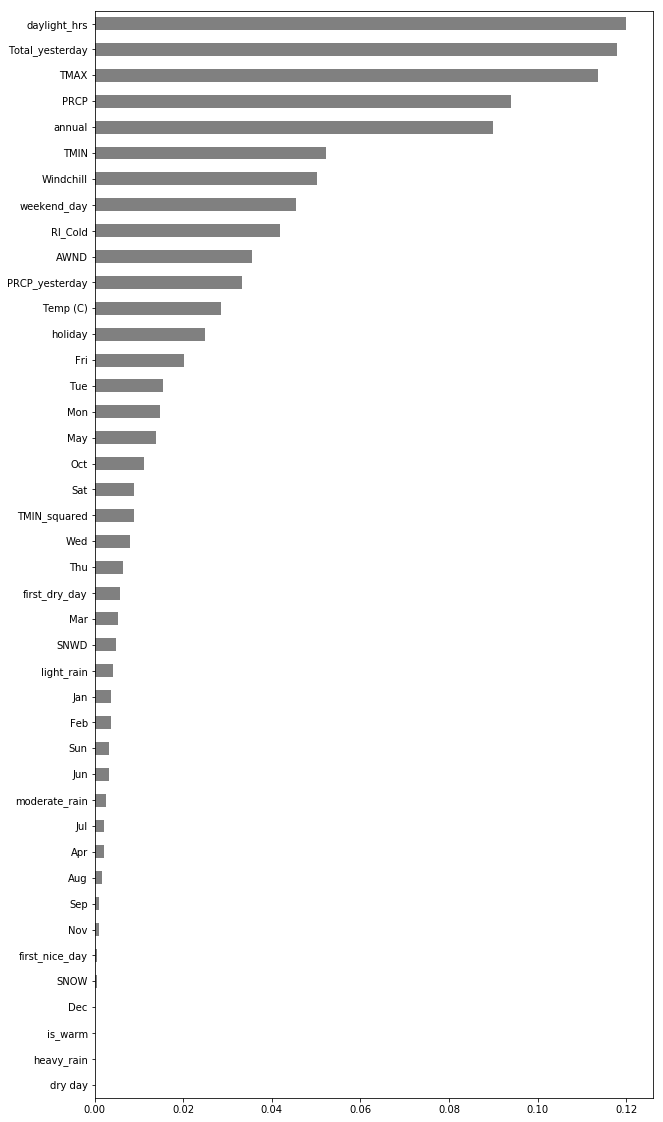

In [34]:
figsize = (10, 20)
importances = pd.Series(best.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color = 'gray', figsize = figsize);

### Permutation Importance

In [85]:
import eli5
from eli5.sklearn import PermutationImportance

# In its current form, eli5 doesn't work with pandas and XGBoost. It needs to be an array. 
## Likely because it renames the columns to some hardcoded value. 
### https://www.kaggle.com/dansbecker/permutation-importance#392299
X_train_dbg = X_train.values
y_train_dbg = y_train.values
X_test_dbg = X_test.values
y_test_dbg = y_test.values

# The model also needs to fit with the nd.array data type
best.fit(X_train_dbg, y_train_dbg)

permuter = PermutationImportance(best, scoring = 'neg_mean_absolute_error',
                                 n_iter = 4, random_state = 42)

permuter.fit(X_test_dbg, y_test_dbg)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=146,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=4, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [86]:
feature_names = X_test.columns.tolist()
eli5.show_weights(permuter, top = None, feature_names = feature_names)

Weight,Feature
615.5157 ± 112.2111,weekend_day
76.3410 ± 40.3514,PRCP
76.3299 ± 11.8805,TMAX
73.9232 ± 12.8643,Total_yesterday
43.5662 ± 18.2356,Fri
26.4764 ± 10.0064,holiday
20.8741 ± 2.9840,Sat
15.2911 ± 5.6626,Tue
13.7877 ± 15.8110,TMIN
13.3202 ± 4.2637,PRCP_yesterday


In [87]:
# For giggles, lets get rid of the noisy features. 

mask = permuter.feature_importances_ > 0

features = X_train.columns[mask]

print('Shape before removing features: ', X_train.shape)
print('Shape after removing features: ' , X_train[features].shape)

Shape before removing features:  (963, 42)
Shape after removing features:  (963, 21)


In [88]:
from sklearn.metrics import mean_absolute_error

best.fit(X_train[features], y_train)
y_pred = best.predict(X_test[features])

mean_absolute_error(y_test, y_pred)

237.79302001953124

### Partial Dependence Plots

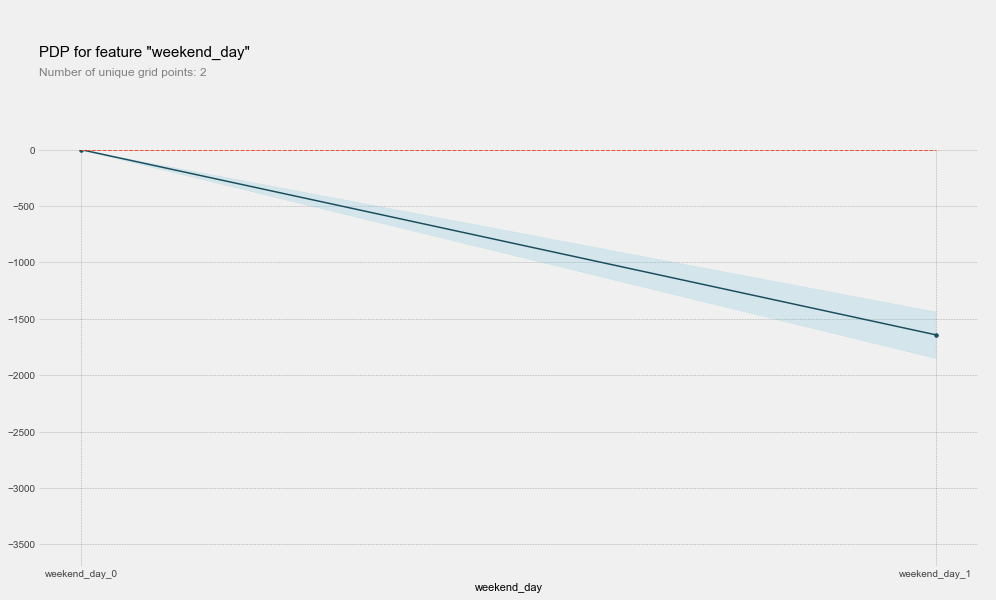

In [89]:
from pdpbox.pdp import pdp_isolate, pdp_plot

plt.style.use('fivethirtyeight')

feature = 'weekend_day'

isolated = pdp_isolate(
    model = best,
    dataset = X_test,
    model_features = features,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

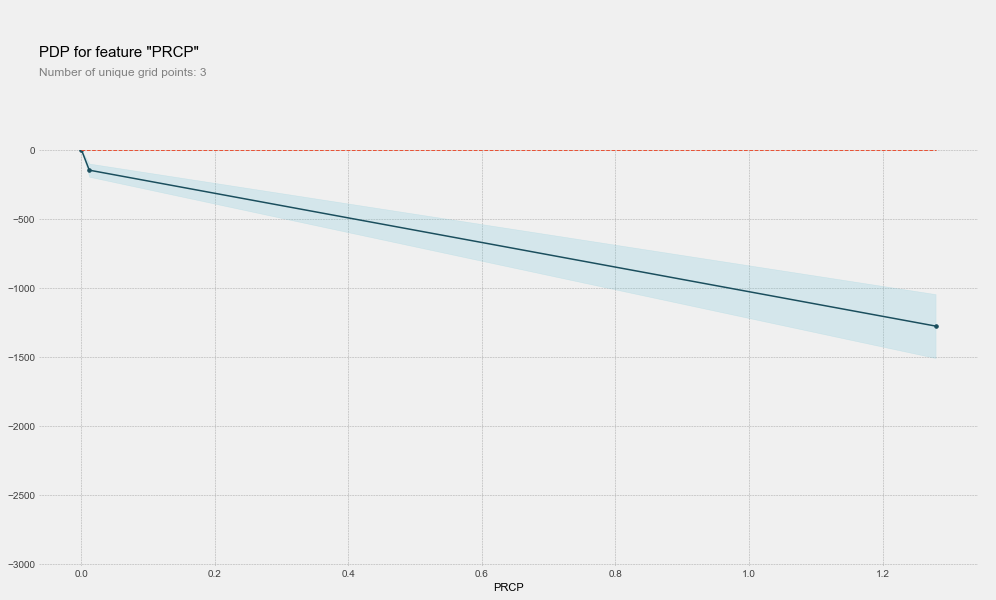

In [90]:
plt.style.use('fivethirtyeight')

feature = 'PRCP'

isolated = pdp_isolate(
    model = best,
    dataset = X_test,
    model_features = features,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

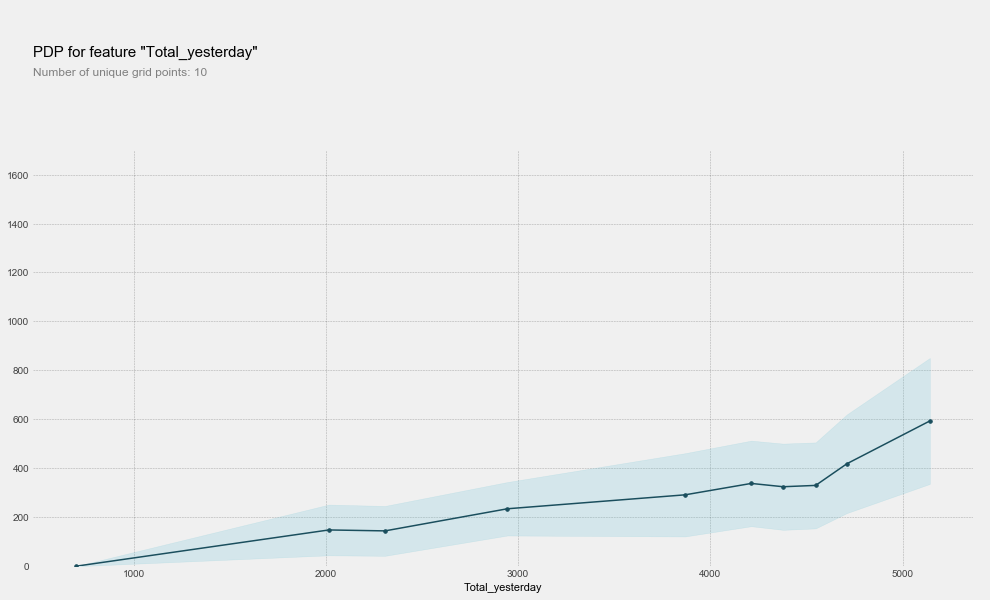

In [91]:
plt.style.use('fivethirtyeight')

feature = 'Total_yesterday'

isolated = pdp_isolate(
    model = best,
    dataset = X_test,
    model_features = features,
    feature = feature
)

pdp_plot(isolated, feature_name=feature);

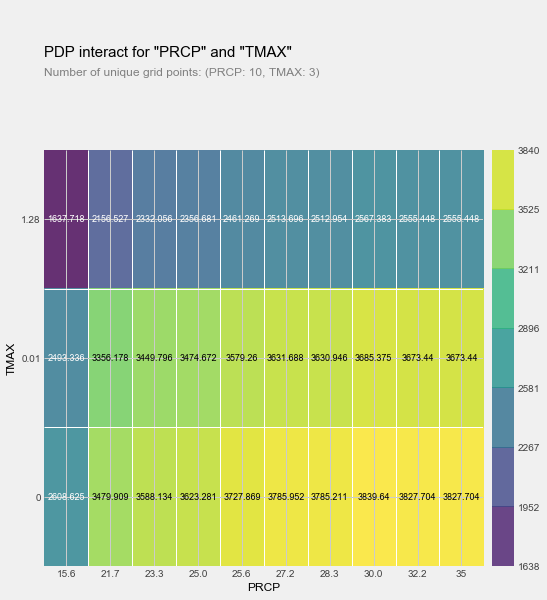

In [95]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

plot_features = ['TMAX', 'PRCP']

interaction = pdp_interact(
    model = best,
    dataset = X_test, 
    model_features = features, 
    features = plot_features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names = features);

### Shapley Values

In [102]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(X_train[features])

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[features].iloc[0,:])

In [106]:
shap.force_plot(explainer.expected_value, shap_values, X_train[features])